In [1]:
!pip install mplfinance
!pip install yfinance


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# ------------------------------
# CONFIG
# ------------------------------
COMPANY = "CBA.AX"              # ticker here 
START = "2020-01-01"       # Start date to read
END = "2023-08-01"         # End date to read
TEST_SIZE = 0.2
TIME_STEP = 60
FUTURE_DAYS = 10

# === Saving options ===
SAVE_TO_DRIVE = False  # set True if running in Google Colab with Drive mounted
DRIVE_PATH = "https://drive.google.com/drive/folders/1I9YUham69toMdBusIAJ9l3fvXBE0gQfC" 

# Create save directory
def make_save_dir():
    if SAVE_TO_DRIVE:
        try:
            os.makedirs(DRIVE_PATH, exist_ok=True)
            return DRIVE_PATH
        except Exception as e:
            print("Could not create Drive folder, saving locally instead:", e)
            
    os.makedirs("./outputs", exist_ok=True)
    return "./outputs"

SAVE_DIR = make_save_dir()

In [4]:
def fetch_prices(ticker, start, end):
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        raise ValueError(f"No data returned for {ticker}.")

    # Flatten MultiIndex: keep only the first level
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Clean up whitespace
    df.columns = [c.strip() for c in df.columns]

    # If "Adj Close" exists, use it as "Close"
    if "Adj Close" in df.columns and "Close" not in df.columns:
        df = df.rename(columns={"Adj Close": "Close"})

    print("Columns after cleaning:", df.columns.tolist())
    return df


In [5]:
# 🔄 UPDATED scale_features (handles missing columns)
def scale_features(df, scaler_type="minmax"):
    # candidate features
    feature_candidates = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    # keep only those actually in df
    feature_cols = [c for c in feature_candidates if c in df.columns]

    X = df[feature_cols].values
    y = df["Close"].values  # target is still Close

    if scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler, feature_cols


def make_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [6]:
def plot_candlestick(df, ticker):
    mpf.plot(
        df,
        type="candle",
        volume=True,
        style="yahoo",
        title=f"{ticker} Candlestick"
    )

def plot_high_low(df, ticker):
    plt.figure(figsize=(12,6))
    plt.plot(df["High"], label="High", linewidth=1.2)
    plt.plot(df["Low"], label="Low", linewidth=1.2)
    plt.title(f"{ticker} High & Low Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def plot_true_vs_pred(ticker, true_prices, pred_prices):
    plt.figure(figsize=(12,6))
    plt.plot(true_prices, label=f"Actual {ticker} Price", linewidth=1.2)
    plt.plot(pred_prices, label=f"Predicted {ticker} Price", linewidth=1.2)
    plt.title(f"{ticker} True vs Predicted Prices (10-day forecast)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [7]:
def save_csvs(ticker, df_hist, pred_array):
    hist_path = os.path.join(SAVE_DIR, f"{ticker}_historical.csv")
    pred_path = os.path.join(SAVE_DIR, f"{ticker}_predictions.csv")
    df_hist.to_csv(hist_path)
    pd.DataFrame(pred_array, columns=["Predicted"]).to_csv(pred_path, index=False)
    print(f"Saved historical CSV: {hist_path}")
    print(f"Saved predictions CSV: {pred_path}")


Processing CBA.AX


C:\Users\ishan\AppData\Local\Temp\ipykernel_29392\206775650.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Columns after cleaning: ['Close', 'High', 'Low', 'Open', 'Volume']


c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


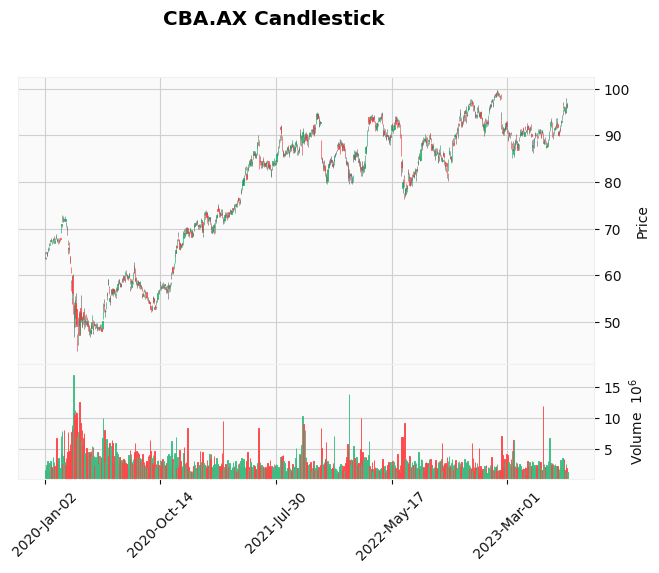

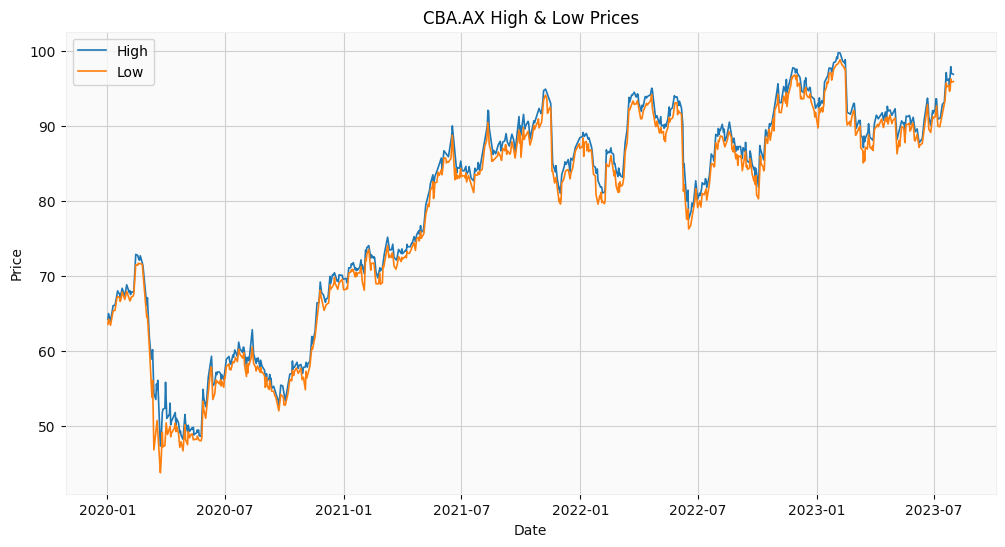

Training shape: (664, 60, 5) (664,)
Testing shape: (121, 60, 5) (121,)


c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
CBA.AX RMSE: 861.9360
CBA.AX MAE: 848.3808


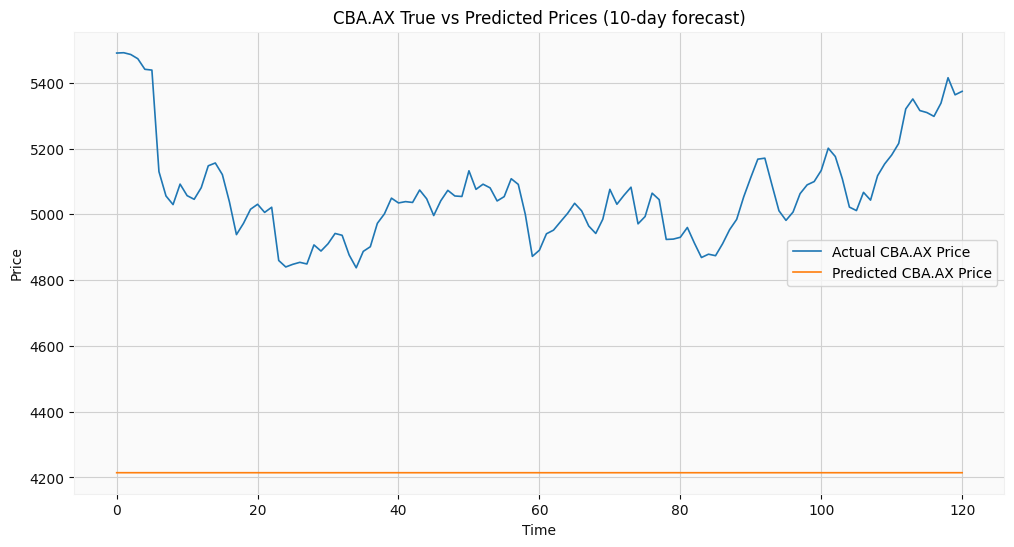

Saved historical CSV: ./outputs\CBA.AX_historical.csv
Saved predictions CSV: ./outputs\CBA.AX_predictions.csv

Done.


In [8]:
print("\n============================")
print(f"Processing {COMPANY}")
print("============================")

# 1) Get data
df = fetch_prices(COMPANY, START, END)

# 2) Candlestick 
plot_candlestick(df, COMPANY)

# 3) High & Low 
plot_high_low(df, COMPANY)

# 4) Prepare data for LSTM
# 🔄 UPDATED for Task C.2
X_scaled, y_all, scaler, feature_cols = scale_features(df, scaler_type="minmax")

# Option A: ratio split
cut = int(len(X_scaled) * (1 - TEST_SIZE))
X_train_raw, X_test_raw = X_scaled[:cut], X_scaled[cut:]
y_train_raw, y_test_raw = y_all[:cut], y_all[cut:]

# Option B (if you want to split by date instead of ratio):
# split_date = pd.to_datetime("2022-01-01")
# train_mask = df.index < split_date
# test_mask  = df.index >= split_date
# X_train_raw, X_test_raw = X_scaled[train_mask], X_scaled[test_mask]
# y_train_raw, y_test_raw = y_all[train_mask], y_all[test_mask]

# === Make sequences for LSTM ===
def make_sequences_multifeature(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(time_step, len(X)):
        Xs.append(X[i-time_step:i, :])  # use all features
        ys.append(y[i])                 # target is Close
    return np.array(Xs), np.array(ys)

X_train, y_train = make_sequences_multifeature(X_train_raw, y_train_raw, TIME_STEP)
X_test,  y_test  = make_sequences_multifeature(X_test_raw,  y_test_raw,  TIME_STEP)

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:",  X_test.shape,  y_test.shape)

# 5) Train model 
# 🔄 UPDATED for Task C.2: multi-feature input
model = build_lstm((TIME_STEP, X_train.shape[2]))
model.fit(X_train, y_train, epochs=24, batch_size=32, verbose=0.1)

# 6) Predictions
pred_scaled = model.predict(X_test)

# Create dummy arrays to inverse transform only Close column
dummy = np.zeros((len(pred_scaled), len(feature_cols)))
dummy[:, feature_cols.index("Close")] = pred_scaled[:, 0]
pred = scaler.inverse_transform(dummy)[:, feature_cols.index("Close")]

dummy_true = np.zeros((len(y_test), len(feature_cols)))
dummy_true[:, feature_cols.index("Close")] = y_test
true = scaler.inverse_transform(dummy_true)[:, feature_cols.index("Close")]

# 7) Metrics (RMSE & MAE)
rmse = np.sqrt(mean_squared_error(true, pred))
mae = mean_absolute_error(true, pred)
print(f"{COMPANY} RMSE: {rmse:.4f}")
print(f"{COMPANY} MAE: {mae:.4f}")

# 8) Plot True vs Predicted 
plot_true_vs_pred(COMPANY, true, pred)

# 9) Future forecasts (fixed for multi-feature input)
last_60 = X_scaled[-TIME_STEP:].reshape(1, TIME_STEP, X_scaled.shape[1])
future_scaled = []
cur = last_60.copy()

close_idx = feature_cols.index("Close")  # get the index of Close column

for _ in range(FUTURE_DAYS):
    next_scaled = model.predict(cur, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
 
    # create dummy row with n_features
    dummy_features = np.zeros((1, 1, X_scaled.shape[1]))
    dummy_features[0, 0, close_idx] = next_scaled

    # slide the window
    cur = np.append(cur[:, 1:, :], dummy_features, axis=1)


# b) Print 10 upcoming days prediction 
#print("\n10 upcoming days prediction:")
#for i, v in enumerate(future_vals, start=1):
    #print(f"Day +{i}: {v:.2f}")

# 10) Save CSVs
#     - historical prices
#     - predictions (for test set)
save_csvs(COMPANY, df, pred)

print("\nDone.")